### Install Packages and Import Dataset

In this notebook, we’ll be working with the **Wisconsin Diagnostic Breast Cancer (WDBC)** dataset again. As a reminder, this dataset contains several features derived from digitized images of breast tumor cells obtained via fine needle aspirates (FNAs).

Each row in the dataset represents one tumor, with a set of measurements calculated from the cell nuclei present in the image. The dataset has the following columns:
- **ID**: Unique identifier for each tumor sample.
- **Diagnosis**: The classification label for the tumor (Malignant or Benign).
- **Radius Mean, Texture Mean, Perimeter Mean, Area Mean**: Various statistical properties of the tumor.
- **Compactness, Concavity, Symmetry**: Other characteristics calculated from the shape and structure of the tumor cells.

The target column is **Diagnosis**, which we will try to predict based on the other features in the dataset.

This dataset was obtained from the UCI Machine Learning Repository, a well-known resource for datasets in the machine learning community.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [10]:
cancer = pd.read_csv('dataset/wdbc.csv')
cancer

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


#### Clean data 
by renaming "M" to "Malignant" and "B" to "Benign" using the `.replace` method. The `.replace` method takes one argument: a dictionary that maps previous values to desired new values.

In [11]:
cancer["diagnosis"] = cancer["diagnosis"].replace({
    "M" : "Malignant",
    "B" : "Benign"
})

cancer["diagnosis"].unique()

array(['Malignant', 'Benign'], dtype=object)

### Evaluating Performance

In Python, the `scikit-learn package` helps both with building a classifier as well as evaluating its performance.

**Golden rule of machine learning**: you cannot use the test data to build the model! If you do, the model gets to “see” the test data in advance, making it look more accurate than it really is. 

How about simplifying it like this:

*Imagine how dangerous it could be if your model incorrectly predicts a patient’s tumor is benign when it’s actually malignant. Overestimating the accuracy of your model could lead to serious mistakes like that.*

Typically, when splitting data for classification tasks, we divide it into a training set and a test set to evaluate the model's performance. The training set, which usually makes up 50% to 95% of the total data, is used to help the model learn patterns and relationships. The remaining 5% to 50% is set aside as the test set, which is used to assess how well the model can handle new, unseen data.

Think of it like preparing a doctor for an exam where they need to decide whether a tumor is cancerous or not. The training set is like the doctor’s study material—cases they practice with to get familiar with the symptoms and patterns of cancerous tumors. But you wouldn’t want to give them all the cases upfront. You need to reserve some unseen cases for the real test, which is where the test set comes in. These are the new cases the doctor faces during the exam, and the goal is to see how well they can apply their learning to fresh examples. If they perform well on the test cases, it shows that they’ve truly understood the task and aren’t just memorizing the practice cases.

In practice, a 75/25 or 80/20 split is common for classification tasks, meaning 75% of the data is used for training and 25% for testing. This balance ensures the model has enough data to learn effectively, while still reserving a significant portion to evaluate how well it performs on new, unseen data. This approach helps prevent overfitting, where the model performs well on the training data but struggles with real-world examples.

For this example, we’ll use 75% of the data for training—so the model has enough information to learn patterns—and 25% for testing, to ensure we have a reliable measure of its performance on unseen cases."

The `train_test_split` function from scikit-learn simplifies data splitting. Key parameters to consider are:

- **`shuffle=True`** (default): Shuffles the data before splitting to avoid any ordering effects.
- **`stratify`**: Ensures the training and testing sets maintain the same class distribution as the original data. For example, if 63% of your data is benign and 37% malignant, using `stratify` ensures these proportions are preserved in both sets.

For reproducibility, we will set a random seed using numpy's `random.seed` function

In [12]:
# set the seed
np.random.seed(1)

In [13]:
#split the data
cancer_train, cancer_test = train_test_split(
    cancer, train_size=0.75, stratify=cancer["diagnosis"]
)

The `info` method shows that the training set has 426 observations and the test set has 143, reflecting a 75%/25% split. To check diagnosis distribution, use `value_counts(normalize=True)` on `cancer_train`. This reveals about 63% benign and 37% malignant cases, confirming that the class proportions were maintained in the split.

In [14]:
cancer_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 426 entries, 164 to 284
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       426 non-null    int64  
 1   diagnosis                426 non-null    object 
 2   radius_mean              426 non-null    float64
 3   texture_mean             426 non-null    float64
 4   perimeter_mean           426 non-null    float64
 5   area_mean                426 non-null    float64
 6   smoothness_mean          426 non-null    float64
 7   compactness_mean         426 non-null    float64
 8   concavity_mean           426 non-null    float64
 9   concave points_mean      426 non-null    float64
 10  symmetry_mean            426 non-null    float64
 11  fractal_dimension_mean   426 non-null    float64
 12  radius_se                426 non-null    float64
 13  texture_se               426 non-null    float64
 14  perimeter_se             426 

In [15]:
cancer_train["diagnosis"].value_counts(normalize=True)

diagnosis
Benign       0.626761
Malignant    0.373239
Name: proportion, dtype: float64

Recall Notebook 1 (Classification 1):

Fit the model on the breast cancer data. 

The `X` argument specifies the predictor variables (independent variables), while the `y` argument specifies the response variable (dependent variable).

Here, 
- `X=cancer_train[["perimeter_mean", "concavity_mean"]]` *to specify both Perimeter and Concavity means are to be used as the predictors.* 
- `y=cancer_train["diagnosis"]` *to specify that diagnosis is the response variable (the one we want to predict)* 

In [16]:
knn = KNeighborsClassifier(n_neighbors=5)
knn

KNeighborsClassifier()

In [17]:
knn.fit(X=cancer_train[["perimeter_mean", "concavity_mean"]], y=cancer_train["diagnosis"])

KNeighborsClassifier()

Using the K-nearest neighbors classifier, we can predict whether each case in the test set is cancerous or not. We then compare these predictions with the actual diagnoses. The `diagnosis` column shows the actual results, and the `predicted` column shows what our classifier predicted. We'll display only the `ID`, `diagnosis`, and `predicted` columns from the test set to assess the classifier's performance.

In [18]:
cancer_test["predicted"] = knn.predict(cancer_test[["perimeter_mean", "concavity_mean"]])
cancer_test[["id", "diagnosis", "predicted"]]

,id,diagnosis,predicted
357,901028,Benign,Benign
361,901041,Benign,Benign
212,8810703,Malignant,Malignant
527,91813702,Benign,Benign
21,8510824,Benign,Benign
...,...,...,...
364,9010877,Benign,Malignant
434,908469,Benign,Benign
299,892399,Benign,Benign
488,913512,Benign,Benign


Since we don't know how good our predictions are, we need to measure their accuracy. One way to assess how well our predictions match the actual labels in the test set is by calculating the **prediction accuracy**.

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$

We can examine accuracy using the `score` method. Here, we pass the test data (predictors) and the actual labels (`cancer_test["diagnosis"]`) to the method. This will evaluate how well the classifier's predictions match the true labels.

In [19]:
knn.score(
    cancer_test[["perimeter_mean", "concavity_mean"]],
    cancer_test["diagnosis"]
)

0.8811188811188811

The output shows that the estimated accuracy of the classifier on the test data was 88%!

Accuracy is a simple and widely used measure to summarize a classifier's performance. However, it only shows how often the model is correct overall and doesn't provide insight into the types of errors it makes. To get a clearer picture, you can use a **confusion matrix**.

### What is a Confusion Matrix?

A confusion matrix breaks down the number of correct and incorrect predictions for each class, revealing the specific kinds of mistakes the classifier tends to make.

**True Positive:** A malignant observation that was classified as malignant (top left).

**False Positive:** A benign observation that was classified as malignant (bottom left).

**True Negative:** A benign observation that was classified as benign (bottom right).

**False Negative:** A malignant observation that was classified as benign (top right).

<table>
  <tr>
    <th></th>
    <th>Predicted Malignant</th>
    <th>Predicted Benign</th>
  </tr>
  <tr>
    <th>Actually Malignant</th>
    <td>True Positive</td>
    <td>False Negative</td>
  </tr>
  <tr>
    <th>Actually Benign</th>
    <td>False Positive</td>
    <td>True Negative</td>
  </tr>
</table>

To view the confusion matrix, we can use the `crosstab` function from pandas. Here, we provide the actual labels as the first argument and the predicted labels as the second argument. 

*Note* that crosstab orders columns alphabetically, so the positive label (Malignant) might not appear in the top left corner but will still be correctly labeled.

In [20]:
pd.crosstab(
    cancer_test["diagnosis"],
    cancer_test["predicted"]
)

predicted,Benign,Malignant
diagnosis,,
Benign,84,6
Malignant,11,42


The confusion matrix reveals the following:

- 42 observations were correctly predicted as malignant.
- 84 observations were correctly predicted as benign.
- 11 observations were incorrectly classified as benign when they were actually malignant.
- 6 observations were incorrectly classified as malignant when they were actually benign.

In a perfect world, the classifier would have no false negatives or false positives and would achieve 100% accuracy. **In practice**, errors are inevitable. Therefore, consider which types of errors matter most for your application and use the confusion matrix to measure them. Key metrics derived from the confusion matrix include **precision** and **recall**:

### Precision

Precision measures how many of the predicted positives are actually positive. High precision means that when the classifier predicts a positive, it's likely to be correct.

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \textbf{False Positives}}
$$

### Recall

Recall measures how many actual positive observations were correctly identified by the classifier. High recall means that if there is a positive instance in the test data, the classifier is likely to detect it.
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \textbf{False Negatives}}
$$

Instead of manually coding the math, you can use the `precision_score` and `recall_score` functions from scikit-learn to compute precision and recall. 

Set the following parameters:
- `y_true`: Actual labels from the diagnosis variable.
- `y_pred`: Predicted labels from the predicted variable.
- `pos_label`: Specify the label to be considered positive.

In [21]:
precision_score(
    y_true=cancer_test["diagnosis"],
    y_pred=cancer_test["predicted"],
    pos_label="Malignant"
)

0.875

Precision calculation by hand:

$$
\text{Precision} = \frac{\text{True Positives (42)}}{\text{True Positives (42)} + \text{False Positives (6)}}
$$

In [22]:
recall_score(
    y_true=cancer_test["diagnosis"],
    y_pred=cancer_test["predicted"],
    pos_label="Malignant"
)

0.7924528301886793

Recall calculation by hand:

$$
\text{Recall} = \frac{\text{True Positives (42)}}{\text{True Positives (42)} + \text{False Negatives (11)}}
$$

The output indicates that the classifier achieved an estimated precision of 87.5% and a recall of 79% on the test data.

### Tuning the Classifier

Most predictive models in statistics and machine learning have parameters that influence their behavior. For instance, in K-nearest neighbors classification, $k$ is a parameter that determines how many neighbors contribute to the class vote. Different values of $k$ result in different classifiers and predictions.

To find the best value for $k$ or tune any model parameter, we aim to maximize the classifier’s accuracy on unseen data. However, the test set should not be used during tuning. Instead, we split the training data into two subsets: one for **training the model** and the other for **evaluating its performance (validation)**. This approach helps select the optimal parameter value while keeping the test set untouched.

so the data split would look like:

![](./images/TVT.001.png)

In Python, we’ll start by creating a single 75-25 train/validation split, training a K-nearest neighbors model, and evaluating its accuracy.

In [23]:
# We're re-using the train_test_split function here in order to split the training data into sub-training and validation sets.
cancer_subtrain, cancer_validation = train_test_split(
    cancer_train, train_size=0.75, stratify=cancer_train["diagnosis"]
)

# fit the model on the sub-training data
knn = KNeighborsClassifier(n_neighbors=3)
X = cancer_subtrain[["perimeter_mean", "concavity_mean"]]
y = cancer_subtrain["diagnosis"]
knn.fit(X, y)

# compute the score on validation data
acc = knn.score(
    cancer_validation[["perimeter_mean", "concavity_mean"]],
    cancer_validation["diagnosis"]
)
acc

0.9252336448598131

The accuracy estimate using this split is 92.5%. 

Now, if we repeat the above code 4 more times, each time generating a new split with a different shuffle of the data, we get five different train/validation splits. 

![](./images/random_folds.001.png)

Each split produces a new accuracy value based on the specific training and validation subsets used. This results in five different accuracy estimates over different runs:

1. 92.5 %
2. 89.7 %
3. 88.8 %
4. 85.9 %
5. 88.7 %

Instead of random splits, we can use **cross-validation** to ensure each observation is in the validation set only once.

### Cross Validation

In cross-validation, we divide the training data into $C$ equal parts. Each part is used once as the validation set while the other $C-1$ parts form the training set. 

So as an example lets try and perform a 5 fold cross-validation.

![](./images/CV.gif)

To perform 5-fold cross-validation in Python using scikit-learn, use the `cross_validate` function. Here’s how:

1. **Set `cv` to 5** for 5 folds.
2. **Provide the training data predictors and labels** as `X` and `y`.

The `cross_validate` function returns a dictionary. Convert it to a pandas DataFrame with `pd.DataFrame` for better visualization. It also automatically handles class stratification in each fold.

In [24]:
knn = KNeighborsClassifier(n_neighbors=3)
X = cancer_train[["perimeter_mean", "concavity_mean"]]
y = cancer_train["diagnosis"]

returned_dictionary = cross_validate(
    estimator=knn,
    cv=5,    # setting up the cross validation number
    X=X,
    y=y
)

cv_5_df = pd.DataFrame(returned_dictionary)    # Converting it to pandas DataFrame

cv_5_df

,fit_time,score_time,test_score
0,0.001118,0.007823,0.906977
1,0.000896,0.001858,0.870588
2,0.000653,0.001817,0.847059
3,0.000650,0.001996,0.894118
4,0.000638,0.001641,0.800000


In [25]:
# Compute mean and standard error of the mean (SEM) for each column
cv_5_metrics = cv_5_df.agg(["mean", "sem"])

cv_5_metrics

,fit_time,score_time,test_score
mean,0.000791,0.003027,0.863748
sem,0.000095,0.001200,0.018948


The validation scores are in the `test_score` column. To summarize the classifier’s performance:

- **Mean (mean)**: Represents the estimated accuracy.
- **Standard Error (sem)**: Indicates the uncertainty around this estimate.

For example, if the mean accuracy is 0.863 and the standard error is 0.019, the true average accuracy is likely between 84.4% and 88.2%, though it could be outside this range. 

### Okay, now what?

To recap, the goal here is to see how accurate our model can be and figure out the best way to make it better. In this case, we still have one parameter we can tweak: the number of neighbors, $K$.

To find the best value for $k$ using cross-validation, we can use `GridSearchCV` from Scikit-learn. It automates the process of trying out different values for $k$ and helps us find the one that gives the best accuracy.

`GridSearchCV` will test various values for $k$ and select the one that yields the best accuracy.

>***Aside***: Number of Folds vs. Number of Neighbors (k)
>
>It’s important not to confuse the **number of folds** in cross-validation with the number of neighbors (k) in KNN.
>
>- **Number of Folds (Cross-Validation)**: Refers to how many parts we split the training data into for evaluation. For example, 5-fold cross-validation trains the model on 4 parts and tests it on the 5th, repeating the process. More folds give a better estimate of model performance but don’t affect the model’s behavior itself.
>
>- **Number of Neighbors (k in KNN)**: Refers to how many neighbors the model considers when making predictions. Smaller `k` values can lead to overfitting, while larger `k` values smooth predictions. Adjusting `k` directly improves model accuracy.


Let's create a `GridSearchCV` object:

-  **Create the GridSearchCV object** by passing:
   - `cancer_tune_pipe` as the `estimator`.
   - `parameter_grid` as the `param_grid`.
   - `cv=10` for 10-fold cross-validation.


In [26]:
"""
The `range` function in Python generates sequences of numbers. 

`range(start, stop, step)` creates a sequence from `start` to `stop-1`, incrementing by `step`. For example, `range(1, 100, 5)` produces 1, 6, 11, ..., 96.
`range(start, stop)` generates numbers from `start` to `stop-1`. For example, `range(1, 4)` produces 1, 2, 3.
`range(stop)` starts from 0 and goes up to `stop-1`. For example, `range(4)` produces 0, 1, 2, 3.
"""

parameter_grid = {
    "n_neighbors": range(1, 100, 5),
}

In [27]:
cancer_tune_grid = GridSearchCV(
    estimator=knn,
    param_grid=parameter_grid,
    cv=10
)

In [33]:
cancer_tune_grid.fit(
    cancer_train[["perimeter_mean", "concavity_mean"]],
    cancer_train["diagnosis"]
)

accuracies_grid = pd.DataFrame(cancer_tune_grid.cv_results_)
accuracies_grid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   mean_fit_time      20 non-null     float64
 1   std_fit_time       20 non-null     float64
 2   mean_score_time    20 non-null     float64
 3   std_score_time     20 non-null     float64
 4   param_n_neighbors  20 non-null     object 
 5   params             20 non-null     object 
 6   split0_test_score  20 non-null     float64
 7   split1_test_score  20 non-null     float64
 8   split2_test_score  20 non-null     float64
 9   split3_test_score  20 non-null     float64
 10  split4_test_score  20 non-null     float64
 11  split5_test_score  20 non-null     float64
 12  split6_test_score  20 non-null     float64
 13  split7_test_score  20 non-null     float64
 14  split8_test_score  20 non-null     float64
 15  split9_test_score  20 non-null     float64
 16  mean_test_score    20 non-nu

From the `GridSearchCV` results, focus on:

- **Number of neighbors** (`param_n_neighbors`)
- **Cross-validation accuracy estimate** (`mean_test_score`)
- **Standard error of the accuracy estimate**

GridSearchCV does not directly provide the standard error, but you can compute it using the standard deviation (`std_test_score`) with the formula:

$$
 \text{Standard Error} = \frac{\text{Standard Deviation}}{\sqrt{\text{Number of Folds}}} 
 $$

This formula allows you to estimate the uncertainty around the accuracy estimate.

In [29]:
accuracies_grid["sem_test_score"] = accuracies_grid["std_test_score"] / 10**(1/2)
accuracies_grid = (
    accuracies_grid[[
        "param_n_neighbors",
        "mean_test_score",
        "sem_test_score"
    ]]
    .rename(columns={"n_neighbors": "param_n_neighbors"})
)
accuracies_grid


,param_n_neighbors,mean_test_score,sem_test_score
0,1,0.861296,0.011966
1,6,0.863898,0.009747
2,11,0.871152,0.012291
3,16,0.875803,0.012239
4,21,0.882835,0.010282
5,26,0.880509,0.011943
6,31,0.887542,0.011177
7,36,0.887542,0.011177
8,41,0.882835,0.012228
9,46,0.882835,0.012228


We can decide which number of neighbors is best by plotting the accuracy versus $K$

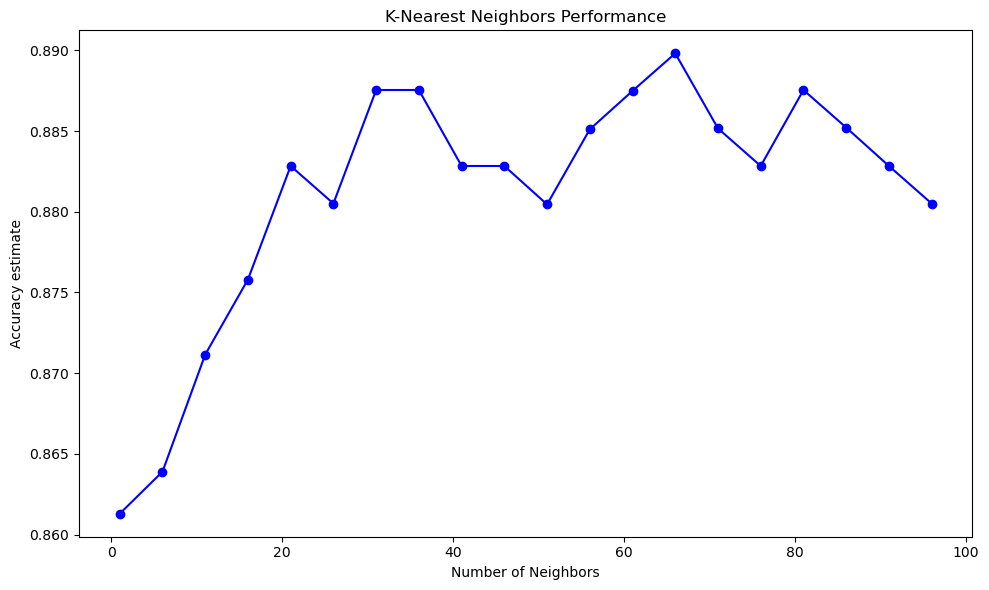

In [30]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot mean test scores with error bars
plt.plot(accuracies_grid['param_n_neighbors'], accuracies_grid['mean_test_score'], '-o', color='blue')

# Add labels and legend
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy estimate')
plt.title('K-Nearest Neighbors Performance')
plt.tight_layout()
plt.show()

We can **also** obtain the number of neighbours with the highest accuracy programmatically by accessing the `best_params_ attribute` of the fit GridSearchCV object. 

*Note*  it is still useful to visualize the results as we did above since this provides additional information on how the model performance varies.

In [31]:
cancer_tune_grid.best_params_

{'n_neighbors': 66}

Choosing 66 neighbors gives the highest cross-validation accuracy estimate at 88.98%. 

Remember, these accuracy estimates are approximations. Even though 66 neighbors shows the highest accuracy here, it doesn't guarantee the classifier is truly better with this setting. When selecting parameters, aim for values where:

- Accuracy is **roughly** optimal, suggesting the model will perform well.
- Nearby values (e.g., slightly higher or lower) don't significantly decrease accuracy, ensuring reliability.
- Training costs are manageable (e.g., avoid excessively large parameters that make predictions costly).

### Underfitting and Overfitting

As you've seen in the above graph, something unusual happens as the number of neighbors ($k$) increases. The cross-validation accuracy might start to drop when $k$ gets too large. This is because the model becomes too general and starts to "underfit" the data. By testing a wider range of $k$ values with `GridSearchCV`, you can see how accuracy changes from small values of $k$ up to nearly the total number of observations.

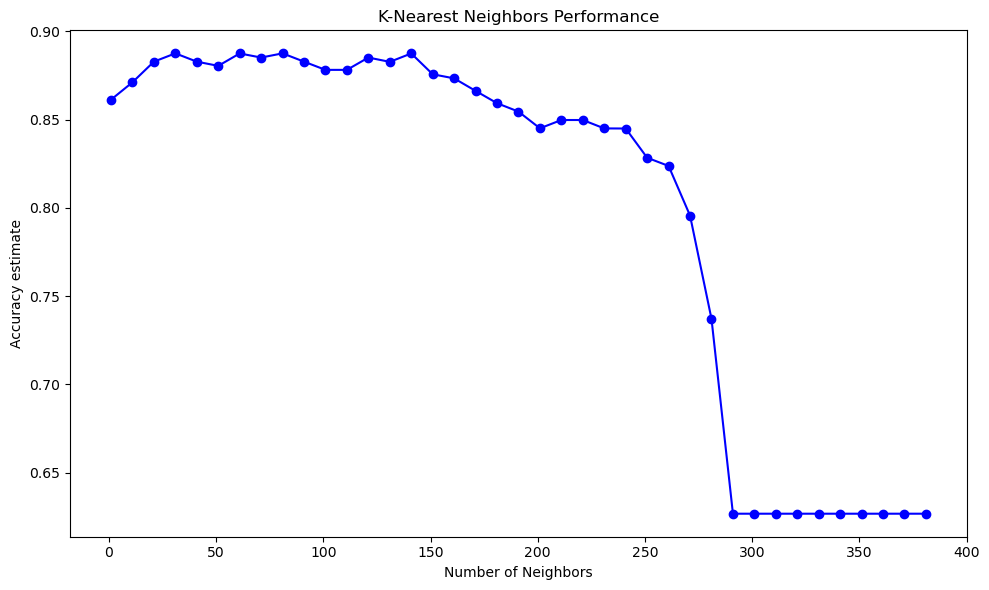

In [32]:
large_param_grid = {
    "n_neighbors": range(1, 385, 10),
}

large_cancer_tune_grid = GridSearchCV(
    estimator=knn,
    param_grid=large_param_grid,
    cv=10
)

large_cancer_tune_grid.fit(
    cancer_train[["perimeter_mean", "concavity_mean"]],
    cancer_train["diagnosis"]
)

large_accuracies_grid = pd.DataFrame(large_cancer_tune_grid.cv_results_)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot mean test scores with error bars
plt.plot(large_accuracies_grid['param_n_neighbors'], large_accuracies_grid['mean_test_score'], '-o', color='blue')

# Add labels and legend
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy estimate')
plt.title('K-Nearest Neighbors Performance')
plt.tight_layout()
plt.show()

As the number of neighbors $k$ increases, the classifier starts to average predictions over more distant points, smoothing the decision boundary and potentially leading to **underfitting**. This means the model becomes too simplistic and less sensitive to individual training examples, which might result in poor performance if the model doesn't capture the complexity of the data.

Conversely, with a very small $k$, each data point has a stronger influence, making the decision boundary more jagged and sensitive to noise in the training data. This can lead to **overfitting**, where the model becomes too tailored to the training set and performs poorly on new, unseen data. In the extreme case where  $k$ is 1, the model simply matches new observations to their nearest training example, which can cause significant variability in predictions based on the training data used.

📼 A video to better visualize underfitting and overfitting:

[![](./images/Underfitting&Overfitting.png)](https://www.youtube.com/watch?v=o3DztvnfAJg)

#### Overview of workflow

1. **Split the Data**: Use `train_test_split` to divide the data into training and test sets. Set `stratify` to the class label column to maintain class distribution. Set the test set aside.

2. **Define the Parameter Grid**: Specify the range of $k$ values to tune.

3. **Perform Grid Search**: Use `GridSearchCV` with a parameter grid to estimate accuracy for different $k$ values.

4. **Execute Grid Search**: Fit the `GridSearchCV` instance on the training data to find the best $k$.

5. **Select Optimal $k$**: Choose the $k$ value with high accuracy and stable performance across nearby values.

6. **Retrain the Model**: Create a new model with the best $k$ and fit it to the training data.

7. **Evaluate the Model**: Assess the model's accuracy on the test set using the `score` method.

### Conclusion

In this notebook, we worked through several steps to classify tumors as either benign or malignant using the Wisconsin Diagnostic Breast Cancer dataset and evaluate their performance. Here's a summary of what we covered:

1. **K-Nearest Neighbors Algorithm (KNN):** We implemented the KNN algorithm and evaluated its performance on a test dataset.

2. **Cross-Validation:** We used cross-validation to determine the optimal 
$k$ value for our classifier.

3. **Underfitting/Overfitting**: We explored how varying $k$ can lead to underfitting or overfitting, discussing the implications of choosing a large or small $k$.

We hope this notebook has provided a practical understanding of data classification, model evaluation, and the application of machine learning algorithms like KNN. Feel free to experiment further with the dataset or the code to enhance your learning!
